In [1]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, write_test_data, gpt_prediction, eval_response, results_path

dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

200
{'all_lower': 78,
 'all_upper': 59,
 'animate': 1,
 'city': 25,
 'even_words': 97,
 'fragment_subject': 20,
 'fragment_verb': 20,
 'gpt4': 200,
 'long': 60,
 'long_margin': 36,
 'margin': 121,
 'nature': 62,
 'odd_words': 103,
 'proper_noun': 32,
 'sentence': 160,
 'shared_sample': 42,
 'short': 140,
 'short_margin': 43,
 'start_cap': 121,
 'start_consonant': 171,
 'start_lower': 79,
 'start_the': 57,
 'start_vowel': 29}


In [13]:
# fragments vs sentence; just subject/verb fragments vs all; test if class balance changes accuracy
tags_true = ["city"]
tags_false = []
tags_common = []

output_dir = results_path / f"sentence_rare_{tags_true[0]}_balanced"
if not output_dir.exists():
    output_dir.mkdir(parents=True)


positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common, true_comb="AND", false_comb="AND")

with open(output_dir / "dataset_tags.txt", "w") as f:
    f.write(f"tags_true: {tags_true}\n")
    f.write(f"tags_false: {tags_false}\n")
    f.write(f"tags_common: {tags_common}\n")

print(len(positives), len(negatives))

25 175


In [16]:
pprint(positives)

[{'input': "Pedestrians navigated through the city's maze-like streets, guided "
           'by the glow of streetlights.',
  'label': True,
  'tags': ['start_cap',
           'city',
           'odd_words',
           'long',
           'long_margin',
           'sentence',
           'start_consonant',
           'gpt4']},
 {'input': 'In the heart of the metropolis, skyscrapers touched the clouds, '
           'reflecting the city lights below.',
  'label': True,
  'tags': ['start_cap',
           'city',
           'odd_words',
           'long',
           'long_margin',
           'sentence',
           'start_vowel',
           'gpt4']},
 {'input': 'The Colosseum is an iconic symbol of ancient Rome.',
  'label': True,
  'tags': ['start_cap',
           'city',
           'odd_words',
           'long',
           'proper_noun',
           'long_margin',
           'sentence',
           'start_consonant',
           'start_the',
           'gpt4']},
 {'input': 'Tokyo is the capit

In [17]:
pprint(negatives)

[{'input': 'java is widely used in enterprise applications.',
  'label': False,
  'tags': ['odd_words',
           'proper_noun',
           'short',
           'sentence',
           'start_lower',
           'start_consonant',
           'margin',
           'gpt4',
           'all_lower']},
 {'input': 'gentle raindrops tapping on the window',
  'label': False,
  'tags': ['even_words',
           'short',
           'start_lower',
           'start_consonant',
           'fragment_subject',
           'margin',
           'gpt4',
           'all_lower']},
 {'input': 'simplicity is the ultimate sophistication.',
  'label': False,
  'tags': ['odd_words',
           'short',
           'sentence',
           'start_lower',
           'start_consonant',
           'short_margin',
           'gpt4',
           'all_lower']},
 {'input': 'sunset casting a warm glow over the horizon',
  'label': False,
  'tags': ['long',
           'even_words',
           'nature',
           'start_lower',

In [19]:
sample_counts = [3, 5, 10]
response_jsons = []
sort_len = lambda x: len(x.split())
for c in sample_counts:
    write_test_data(positives, negatives, c, output_dir, tiled=True, prompt_sort_by=sort_len)
    in_context_prompt = open(output_dir / f"in_context_prompt_{c}.txt").read()
    test_prompt = open(output_dir / f"test_prompt_{c}.txt").read()
    test_samples = json.load(open(output_dir / f"test_samples_{c}.json"))
    response_json = gpt_prediction(in_context_prompt, test_prompt, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{c}.json", "w"))
    response_jsons.append(response_json)

In [8]:
sample_counts = [3, 5, 10]
response_jsons = [json.load(open(output_dir / f"response_{c}.json")) for c in sample_counts]
test_samples = [json.load(open(output_dir / f"test_samples_{c}.json")) for c in sample_counts]

results = []
responses = []
for r, t in zip(response_jsons, test_samples):
    response, result = eval_response(r, t)
    results.append(result)
    responses.append(response)

In [9]:
for c, r in zip(sample_counts, results):
    r["in_context_count"] = c
pprint(results)

[{'accuracy': 0.75,
  'correct': 69,
  'corrupted': 0,
  'false': 70,
  'in_context_count': 3,
  'incorrect': 23,
  'mismatch': 0,
  'precision': 0.4883720930232558,
  'recall': 0.9545454545454546,
  'total': 92,
  'true': 22},
 {'accuracy': 0.8888888888888888,
  'correct': 80,
  'corrupted': 0,
  'false': 70,
  'in_context_count': 5,
  'incorrect': 10,
  'mismatch': 0,
  'precision': 0.6923076923076923,
  'recall': 0.9,
  'total': 90,
  'true': 20},
 {'accuracy': 0.8823529411764706,
  'correct': 75,
  'corrupted': 0,
  'false': 70,
  'in_context_count': 10,
  'incorrect': 10,
  'mismatch': 0,
  'precision': 0.6086956521739131,
  'recall': 0.9333333333333333,
  'total': 85,
  'true': 15}]


In [10]:
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

   correct  mismatch  incorrect  corrupted  total  precision    recall  true  \
0       39         0          5          0     44   0.869565  0.909091    22   
1       37         0          3          0     40   0.869565  1.000000    20   
2       28         0          2          0     30   0.882353  1.000000    15   

   false  in_context_count  
0     22                 3  
1     20                 5  
2     15                10  
                   correct  mismatch  incorrect  corrupted  precision  \
in_context_count                                                        
3                 0.886364       0.0   0.113636        0.0   0.869565   
5                 0.925000       0.0   0.075000        0.0   0.869565   
10                0.933333       0.0   0.066667        0.0   0.882353   

                    recall  true  false  test_total  
in_context_count                                     
3                 0.909091   0.5    0.5    0.936170  
5                 1.000000   0.5   

Text(0.5, 1.0, 'City scene balanced (n=47, T=1)')

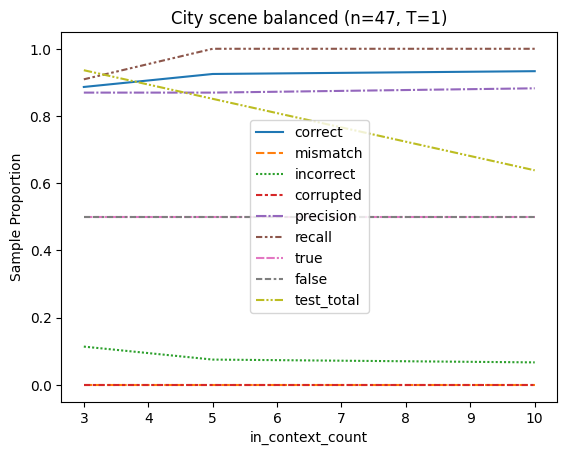

In [14]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)
total_samples = df["total"].max() + df["in_context_count"].min()

print(df)
for col in df.columns:
    if col in ["total", "in_context_count", "precision", "recall"]:
        continue
    df[col] /= df["total"]
df["total"] /= total_samples
df["test_total"] = df["total"]
df.drop(columns=["total"], inplace=True)
df.set_index("in_context_count", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Proportion")
ax.set_title(f"City scene balanced (n={total_samples}, T=1)")